In [1]:
from os import path, makedirs, walk,listdir, remove
import pandas as pd
from shutil import copyfile
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, RandomZoom, RandomRotation, RandomFlip, RandomContrast, Rescaling
from keras.backend import clear_session
from keras.utils import image_dataset_from_directory, split_dataset
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, Precision, Recall, F1Score, TrueNegatives, TruePositives, FalseNegatives, FalsePositives
from keras.callbacks import EarlyStopping
from random import choice

In [2]:
DATASET_NAMES = ('train','valid','test')
CLASS_DIRECTORY_NAMES = ('class_fracture','class_no_fracture')
DATASET_DIRECTORY = 'retinanet_data_format'
TOP_DIRECTORY_CLASSIFIFICATIONS = path.join(DATASET_DIRECTORY ,'categorised_images')
AUGMENTATION_LAYERS = [RandomFlip("horizontal"), RandomRotation(0.2), RandomZoom(0.2), RandomContrast(0.2)]

#Hyperparameters
OPTIMIZER = Adam
LEARNING_RATE = 0.0001
LOSS_FUNCTION = BinaryCrossentropy
METRICS = [BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), F1Score(name='f1'), TrueNegatives(name='tn'), TruePositives(name='tp'), FalseNegatives(name='fn'), FalsePositives(name='fp')]
EPOCHS = 50
BATCH_SIZE = 10
VERBOSE = 1
REGULARIZER=None
VALIDATION_SPLIT = 0.2
INPUT_SHAPE = (256,256,1)

2024-03-25 13:07:22.499655: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-03-25 13:07:22.499686: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-25 13:07:22.499693: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-25 13:07:22.499967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-25 13:07:22.499984: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
def categorise_images(a_dataset_name):
    #creates a directory structure  like: images/
    #                                       class0/*.jpg
    #                                       class1/*.jpg
    #and copies the images into either leaf directory depending on their class label
    #this puts the data into a format that keras can load into a dataset

    fracture_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, a_dataset_name,CLASS_DIRECTORY_NAMES[0])
    print('fracture_directory', fracture_directory)
    no_fracture_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS,a_dataset_name,CLASS_DIRECTORY_NAMES[-1])
    print('no_fracture_directory', no_fracture_directory)

    if path.exists(fracture_directory) == False:  
        makedirs(fracture_directory) 
    if path.exists(no_fracture_directory) == False:  
        makedirs(no_fracture_directory) 

    #read labels into pandas df
    csv_filepath = path.join(DATASET_DIRECTORY, a_dataset_name, 'labels/labels.csv')
    print('csv_filepath', csv_filepath)
    df = pd.read_csv(path.join(csv_filepath))
    df = df.set_index('filename')

    #walk through files and copy file to relevant directory
    images_dir = path.join(DATASET_DIRECTORY,a_dataset_name,'images')
    print('images_dir', images_dir)
    filenames = []
    for (dirpath, dirnames, filenames) in walk(images_dir):
        filenames.extend(filenames)
 
    for filename in filenames:
        #ignore mac os system file
        if filename.endswith('.DS_Store'):
            pass
        elif df.loc[filename]['target'] == 1:
            destination = path.join(fracture_directory, filename)
        else:
            destination = path.join(no_fracture_directory, filename)
        source = path.join(images_dir, filename)
        copyfile(source, destination)

In [4]:
for dataset_name in DATASET_NAMES:
    categorise_images(dataset_name)

fracture_directory dataset/categorised_images/train/class_fracture
no_fracture_directory dataset/categorised_images/train/class_no_fracture
csv_filepath dataset/train/labels/labels.csv
images_dir dataset/train/images
fracture_directory dataset/categorised_images/valid/class_fracture
no_fracture_directory dataset/categorised_images/valid/class_no_fracture
csv_filepath dataset/valid/labels/labels.csv
images_dir dataset/valid/images
fracture_directory dataset/categorised_images/test/class_fracture
no_fracture_directory dataset/categorised_images/test/class_no_fracture
csv_filepath dataset/test/labels/labels.csv
images_dir dataset/test/images


In [4]:
#remove any non-jpg files in the directories
def find_and_remove_non_jpg_files(a_folder_path):
    #removes any non-jpg files in the provided directory
    num_skipped = 0
    for fname in listdir(a_folder_path):
        fpath = path.join(a_folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            print('removing non-image file: ' + fpath)
            remove(fpath)

    print(f"Deleted {num_skipped} files.")

In [5]:
#remove any non-processable files from the image directories
folders_checked = 0
for dataset_name in DATASET_NAMES:
    for class_dir_name in CLASS_DIRECTORY_NAMES:
        folder_path = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name,class_dir_name)
        print('checking folder: '+folder_path)
        find_and_remove_non_jpg_files(folder_path)
        folders_checked +=1
print('checked', folders_checked, 'folders')

checking folder: retinanet_data_format/categorised_images/train/class_fracture
Deleted 0 files.
checking folder: retinanet_data_format/categorised_images/train/class_no_fracture
Deleted 0 files.
checking folder: retinanet_data_format/categorised_images/valid/class_fracture
Deleted 0 files.
checking folder: retinanet_data_format/categorised_images/valid/class_no_fracture
Deleted 0 files.
checking folder: retinanet_data_format/categorised_images/test/class_fracture
Deleted 0 files.
checking folder: retinanet_data_format/categorised_images/test/class_no_fracture
Deleted 0 files.
checked 6 folders


In [6]:
def load_images(dataset_name):
    
    return image_dataset_from_directory(
    directory= path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name),
    labels='inferred',
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False
)

In [7]:
#Load the images into datasets
train_ds= load_images('train')
test_ds = load_images('test')
valid_ds = load_images('valid')
print('train_ds', train_ds.cardinality())
print('test_ds', test_ds.cardinality())
print('valid_ds', valid_ds.cardinality())

#create a combined dataset so the data can be shuffled and then split into training and test sets
combined_ds = train_ds.concatenate(valid_ds)
print('combined_ds', combined_ds.cardinality())

Found 3630 files belonging to 2 classes.
Found 168 files belonging to 2 classes.
Found 347 files belonging to 2 classes.
train_ds tf.Tensor(363, shape=(), dtype=int64)
test_ds tf.Tensor(17, shape=(), dtype=int64)
valid_ds tf.Tensor(35, shape=(), dtype=int64)
combined_ds tf.Tensor(398, shape=(), dtype=int64)


In [8]:
combined_images = []
combined_labels = []
for images, labels in combined_ds.as_numpy_iterator():
    combined_images.extend(images)
    combined_labels.extend(labels)
combined_images = np.array(combined_images)
combined_labels = np.array(combined_labels)

test_images = []
test_labels = []
for images, labels in test_ds.as_numpy_iterator():
    test_images.extend(images)
    test_labels.extend(labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

train_images = []
train_labels = []
for images, labels in train_ds.as_numpy_iterator():
    train_images.extend(images)
    train_labels.extend(labels)
train_images = np.array(train_images)
train_labels = np.array(train_labels)

valid_images = []
valid_labels = []
for images, labels in valid_ds.as_numpy_iterator():
    valid_images.extend(images)
    valid_labels.extend(labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)


X_train = train_images
y_train = train_labels
X_valid = valid_images
y_valid = valid_labels
X_test = test_images
y_test = test_labels

print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('X_valid', X_valid.shape)
print('y_valid', y_valid.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

2024-03-25 13:07:54.187623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-25 13:07:54.498356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-25 13:07:54.787502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_train (3630, 256, 256, 1)
X_test (168, 256, 256, 1)
X_valid (347, 256, 256, 1)
y_valid (347, 1)
y_train (3630, 1)
y_test (168, 1)


2024-03-25 13:07:55.039805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


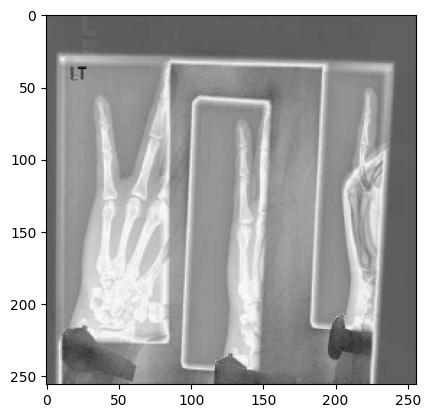

In [9]:
random_training_image = choice(X_train)
plt.imshow(random_training_image, cmap='gray')
plt.show()

In [10]:
def create_model(input_shape):

    #create a Sequential  model
    model = Sequential()

    #Add the layers
    model.add(Input(input_shape))
    model.add(Rescaling(1.0 / 255))
    for augmentation_layer in AUGMENTATION_LAYERS:
        model.add(augmentation_layer)
    #Add 2 convolutional layers paired with max pooling layers
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    #Flatten the output so that it can be processed as a Vector by the subsequent Dense layer
    model.add(Flatten())

    #add a fully connected layer with  64 neurons and a relu activation function outut shape = 64
    model.add(Dense(256, kernel_regularizer=REGULARIZER, activation='relu'))
    #add output layer with a single neuron and a sigmoind activation to represent the binary classification
    model.add(Dense(1, kernel_regularizer=REGULARIZER, activation='sigmoid'))

    return model

In [11]:
model = create_model(INPUT_SHAPE)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 256, 256, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 256, 256, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,352,577 (226.41 MB)

 Trainable params: 59,352,577 (226.41 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
def train_model(X_train, y_train, X_valid, y_valid):
    
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, verbose=VERBOSE, restore_best_weights=True)]
    
    model = create_model(INPUT_SHAPE)
    model.compile(optimizer=OPTIMIZER(LEARNING_RATE), loss=LOSS_FUNCTION(), metrics=METRICS)
    model_history = model.fit(
                            X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_valid, y_valid),
                            verbose=VERBOSE)
    clear_session()

    return (model, model_history)

In [14]:
model, model_history = train_model(X_train, y_train, X_valid, y_valid)

Epoch 1/50


2024-03-25 13:08:48.229900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


363/363 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.5042 - f1: 0.6673 - fn: 259.1923 - fp: 649.7967 - loss: 0.6973 - precision: 0.5106 - recall: 0.6931 - tn: 259.8049 - tp: 656.1786 - val_accuracy: 0.5447 - val_f1: 0.6705 - val_fn: 49.0000 - val_fp: 109.0000 - val_loss: 0.6923 - val_precision: 0.5362 - val_recall: 0.7200 - val_tn: 63.0000 - val_tp: 126.0000
Epoch 2/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - accuracy: 0.5142 - f1: 0.6569 - fn: 376.9286 - fp: 500.5577 - loss: 0.6931 - precision: 0.5043 - recall: 0.5715 - tn: 410.6621 - tp: 536.8242 - val_accuracy: 0.5533 - val_f1: 0.6705 - val_fn: 58.0000 - val_fp: 97.0000 - val_loss: 0.6928 - val_precision: 0.5467 - val_recall: 0.6686 - val_tn: 75.0000 - val_tp: 117.0000
Epoch 3/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 44s 120ms/step - accuracy: 0.5353 - f1: 0.6722 - fn: 386.5879 - fp: 467.4451 - loss: 0.6878 - precision: 0.5361 - recall: 0.6007 - tn: 436.6896 - tp: 534.2500 - val_accuracy: 0.5072 - val_f1: 0.6705 - val_fn: 126.0000 

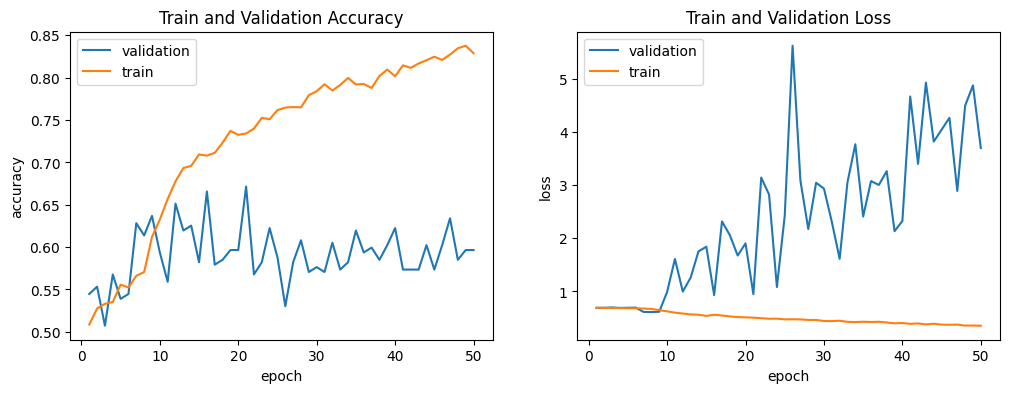

In [15]:
#plot the model accuracy and loss]
epochs = len(model_history.history['accuracy'])
train_accuracy = model_history.history['accuracy']
valid_accuracy = model_history.history['val_accuracy']
train_loss = model_history.history['loss']
valid_loss = model_history.history['val_loss']

fig, (accuracy, loss) = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_size_inches(12,4 )
accuracy.plot(range(1, epochs+1), valid_accuracy) 
accuracy.plot(range(1, epochs+1), train_accuracy)  
accuracy.set_ylabel('accuracy')
accuracy.set_xlabel('epoch')
accuracy.legend(['validation','train'], loc='upper left')
accuracy.set_title('Train and Validation Accuracy')

loss.plot(range(1, epochs+1), valid_loss)
loss.plot(range(1, epochs+1), train_loss)
loss.set_ylabel('loss')
loss.set_xlabel('epoch')
loss.legend(['validation', 'train'], loc='upper left')
loss.set_title('Train and Validation Loss')

plt.show()

In [16]:
results  = model.evaluate(X_test, y_test)
print('accuracy', results[1])
print('loss', results[0])
print('precision', results[2])
print('recall', results[3])
print('f1', results[4])
print('tn', results[5])
print('tp', results[6])
print('fn', results[7])
print('fp', results[8])

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.6653 - f1: 0.6532 - fn: 30.4286 - fp: 9.0000 - loss: 0.6556 - precision: 0.7451 - recall: 0.4711 - tn: 50.2857 - tp: 26.8571
accuracy 0.6547619104385376
loss 0.6322436332702637
precision 0.6771653294563293
recall 46.0
f1 12.0
tn 0.7692307829856873
tp 0.4651162922382355
fn 70.0
fp 40.0


In [ ]:
import datetime
print("Last modified: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S") + "\n")